# Proyek Analisis Data: [Input Nama Dataset]
- **Nama:** capstone team

## Menentukan Pertanyaan Bisnis

## Import Semua Packages/Library yang Digunakan

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import random
from PIL import Image
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dense, Flatten, \
                          Dropout, Input,GlobalAveragePooling2D,BatchNormalization)
from tensorflow.keras.activations import softmax
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from mpl_toolkits.axes_grid1 import ImageGrid
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import (ConfusionMatrixDisplay, confusion_matrix, 
                             accuracy_score)
import cv2
import numpy as np 
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import power_transform
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor


## Data Wrangling

### Training Data

In [3]:
train2=os.listdir("train")

In [4]:
train2

['Acne and Rosacea',
 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions',
 'Atopic Dermatitis',
 'Bullous Disease',
 'Cellulitis Impetigo and other Bacterial Infections',
 'Eczema',
 'Exanthems and Drug Eruptions',
 'Hair Loss Photos Alopecia and other Hair Diseases',
 'Herpes HPV and other STDs',
 'Light Diseases and Disorders of Pigmentation',
 'Lupus and other Connective Tissue Diseases',
 'Melanoma Skin Cancer Nevi and Moles',
 'Nail Fungus and other Nail Disease',
 'Poison Ivy Photos and other Contact Dermatitis',
 'Psoriasis pictures Lichen Planus and Related Diseases',
 'Scabies Lyme Disease and other Infestations and Bites',
 'Seborrheic Keratoses and other Benign Tumors',
 'Systemic Disease',
 'Tinea Ringworm Candidiasis and other Fungal Infections',
 'Urticaria Hives',
 'Vascular Tumors',
 'Vasculitis Photos',
 'Warts Molluscum and other Viral Infections']

In [5]:
cat2=['Acne and Rosacea']

In [6]:
cat = ['Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Atopic Dermatitis']

In [7]:
def data_dictionary():
    path_train = "train/"  # Update the path to your train directory
    path_test = "test/"    # Update the path to your test directory
    
    list_train = os.listdir(path_train)
    list_train1 = os.listdir(path_test)
    
    train_dictionary = {"image_path": [], "target": []}
    
    k = 0
    for i in list_train:
        path_disease_train = os.path.join(path_train, i)
        image_list_train = os.listdir(path_disease_train)
        for j in image_list_train:
            img_path_train = os.path.join(path_disease_train, j)
            if img_path_train != "train/Normal/34.avif":
                train_dictionary["image_path"].append(img_path_train)
                train_dictionary['target'].append(k) 
        k += 1
    
    for i in list_train1:
        path_disease_test = os.path.join(path_test, i)
        image_list_test = os.listdir(path_disease_test)
        for j in image_list_test:
            img_path_train = os.path.join(path_disease_test, j)
            train_dictionary["image_path"].append(img_path_train)
            train_dictionary['target'].append(4)
    
    train_df = pd.DataFrame(train_dictionary)
    return train_df

train = data_dictionary()


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4876 entries, 0 to 4875
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  4876 non-null   object
 1   target      4876 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 76.3+ KB


In [9]:
import cv2
images=[]
label=[]
for i in train['image_path']:
    if i!="train/Normal/34.avif":
        img=cv2.imread(i)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img=cv2.resize(img,(180,180))
        
        images.append(img)


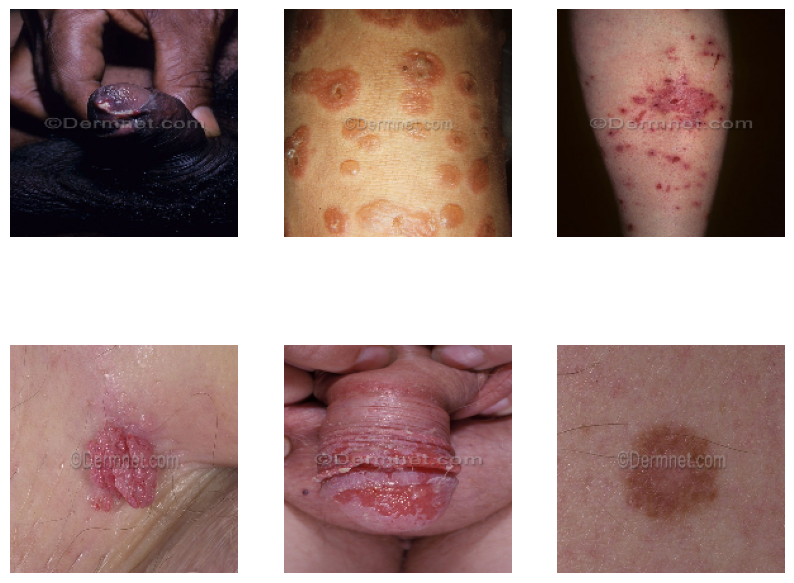

In [10]:
# Create a list of example inputs to our Gradio demo
example_list = [image for image in random.sample(images, k=6)]

# Plot the images in a 2x3 grid
fig, axes = plt.subplots(2, 3, figsize=(10, 8))

for ax, img_array in zip(axes.ravel(), example_list):
    ax.imshow(img_array)
    ax.axis('off')

plt.show()


In [11]:
# Ensure the environment is reset
import gc
gc.collect()
tf.keras.backend.clear_session()

# Preprocess labels
labels = np.array(train['target'])

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

# Convert data to numpy arrays
X_train = np.array(X_train)
X_val = np.array(X_val)
y_train = np.array(y_train)
y_val = np.array(y_val)

# Normalize pixel values
X_train = X_train / 255.0
X_val = X_val / 255.0

# One-hot encode the labels
y_train = tf.keras.utils.to_categorical(y_train, num_classes=23)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=23)

# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Dropout(0.25),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Dropout(0.25),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Dropout(0.25),
    
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(23, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks for early stopping and model checkpoint
callbacks = [
    EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')
]

# Train the model
history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=50, 
                    batch_size=32, 
                    callbacks=callbacks)

# Save the final model
model.save('final_model.h5')

# Plot the training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')

plt.show()


Epoch 1/50
122/122 [==============================] - 101s 817ms/step - loss: 4.1652 - accuracy: 0.0788 - val_loss: 3.2959 - val_accuracy: 0.0502
Epoch 2/50
122/122 [==============================] - 97s 790ms/step - loss: 3.2621 - accuracy: 0.1411 - val_loss: 3.5100 - val_accuracy: 0.0574
Epoch 3/50
122/122 [==============================] - 96s 790ms/step - loss: 2.9352 - accuracy: 0.1920 - val_loss: 3.1357 - val_accuracy: 0.0922
Epoch 4/50
107/122 [=========================>....] - ETA: 11s - loss: 2.6397 - accuracy: 0.2456

In [4]:
import tensorflow as tf
print(tf.__version__)


AttributeError: module 'tensorflow' has no attribute '__version__'

In [2]:
# ======================================================================================================
# PROBLEM A3
#
# Build a classifier for the Human or Horse Dataset with Transfer Learning.
# The test will expect it to classify binary classes.
# Note that all the layers in the pre-trained model are non-trainable.
# Do not use lambda layers in your model.
#
# The horse-or-human dataset used in this problem is created by Laurence Moroney (laurencemoroney.com).
# Inception_v3, pre-trained model used in this problem is developed by Google.
#
# Desired accuracy and validation_accuracy > 97%.
# =======================================================================================================

import urllib.request
import zipfile
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

tf.keras.backend.clear_session()

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('acc') > 0.97 and logs.get('val_acc') > 0.97):
            self.model.stop_training = True

def solution_A3():
    # Download the InceptionV3 weights
    inceptionv3 = 'https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
    urllib.request.urlretrieve(inceptionv3, 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')
    local_weights_file = 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

    # Load the pre-trained InceptionV3 model
    pre_trained_model = InceptionV3(weights=local_weights_file, input_shape=(150, 150, 3), include_top=False)

    # Freeze all layers in the pre-trained model
    for layer in pre_trained_model.layers:
        layer.trainable = False

    # Get the output of the pre-trained model
    last_layer = pre_trained_model.output

    # Download and extract the dataset
    data_url_1 = 'https://github.com/dicodingacademy/assets/releases/download/release-horse-or-human/horse-or-human.zip'
    urllib.request.urlretrieve(data_url_1, 'horse-or-human.zip')
    local_file = 'horse-or-human.zip'
    zip_ref = zipfile.ZipFile(local_file, 'r')
    zip_ref.extractall('data/horse-or-human')
    zip_ref.close()

    data_url_2 = 'https://github.com/dicodingacademy/assets/raw/main/Simulation/machine_learning/validation-horse-or-human.zip'
    urllib.request.urlretrieve(data_url_2, 'validation-horse-or-human.zip')
    local_file = 'validation-horse-or-human.zip'
    zip_ref = zipfile.ZipFile(local_file, 'r')
    zip_ref.extractall('data/validation-horse-or-human')
    zip_ref.close()

    # Define the directories for training and validation data
    train_dir = 'data/horse-or-human'
    validation_dir = 'data/validation-horse-or-human'

    # Data augmentation for training images
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       rotation_range=40,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       fill_mode='nearest')

    # Data augmentation for validation images
    validation_datagen = ImageDataGenerator(rescale=1./255)

    # Generate training data
    train_generator = train_datagen.flow_from_directory(train_dir,
                                                        target_size=(150, 150),
                                                        batch_size=20,
                                                        class_mode='binary')

    # Generate validation data
    validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                                  target_size=(150, 150),
                                                                  batch_size=20,
                                                                  class_mode='binary')

    # Add custom layers on top of the pre-trained model
    x = layers.Flatten()(last_layer)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(1, activation='sigmoid')(x)

    # Create the final model
    model = Model(pre_trained_model.input, x)

    # Compile the model
    model.compile(optimizer=RMSprop(lr=0.0001),
                  loss='binary_crossentropy',
                  metrics=['acc'])

    # Define callbacks for early stopping
    callbacks = myCallback()

    # Train the model
    history = model.fit(train_generator,
                        steps_per_epoch=100,
                        epochs=30,
                        validation_data=validation_generator,
                        validation_steps=50,
                        verbose=1,
                        callbacks=[callbacks])

    return model

# The code below is to save your model as a .h5 file.
# It will be saved automatically in your Submission folder.
if __name__ == '__main__':
    # DO NOT CHANGE THIS CODE
    model = solution_A3()
    model.save("model_A3.h5")


Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 33s 296ms/step - loss: 3.0825 - acc: 0.8190 - val_loss: 0.0081 - val_acc: 0.9961


In [3]:
# =====================================================================================
# PROBLEM A2
#
# Build a Neural Network Model for Horse or Human Dataset.
# The test will expect it to classify binary classes.
# Your input layer should accept 150x150 with 3 bytes color as the input shape.
# Don't use lambda layers in your model.
#
# The dataset used in this problem is created by Laurence Moroney (laurencemoroney.com).
#
# Desired accuracy and validation_accuracy > 83%
# ======================================================================================

import urllib.request
import zipfile
import tensorflow as tf
import os
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop

class StopTrainingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is not None:
            accuracy = logs.get('accuracy')
            val_accuracy = logs.get('val_accuracy')
            if accuracy and val_accuracy and accuracy > 0.83 and val_accuracy > 0.83:
                self.model.stop_training = True

def solution_A2():
    # Download and extract the training dataset
    train_data_url = 'https://github.com/dicodingacademy/assets/releases/download/release-horse-or-human/horse-or-human.zip'
    urllib.request.urlretrieve(train_data_url, 'horse-or-human.zip')
    with zipfile.ZipFile('horse-or-human.zip', 'r') as zip_ref:
        zip_ref.extractall('data/horse-or-human')

    # Download and extract the validation dataset
    val_data_url = 'https://github.com/dicodingacademy/assets/raw/main/Simulation/machine_learning/validation-horse-or-human.zip'
    urllib.request.urlretrieve(val_data_url, 'validation-horse-or-human.zip')
    with zipfile.ZipFile('validation-horse-or-human.zip', 'r') as zip_ref:
        zip_ref.extractall('data/validation-horse-or-human')

    # Set up the training data generator
    train_datagen = ImageDataGenerator(
        rescale=1.0/255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    train_generator = train_datagen.flow_from_directory(
        'data/horse-or-human',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary'
    )

    # Set up the validation data generator
    val_datagen = ImageDataGenerator(rescale=1.0/255)

    val_generator = val_datagen.flow_from_directory(
        'data/validation-horse-or-human',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary'
    )

    # Build the neural network model
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(
        loss='binary_crossentropy',
        optimizer=RMSprop(learning_rate=0.001),
        metrics=['accuracy']
    )

    # Train the model with early stopping callback
    model.fit(
        train_generator,
        epochs=30,
        validation_data=val_generator,
        callbacks=[StopTrainingCallback()],
        verbose=1
    )

    return model

# The code below is to save your model as a .h5 file.
# It will be saved automatically in your Submission folder.
if __name__ == '__main__':
    # DO NOT CHANGE THIS CODE
    model = solution_A2()
    model.save("model_A2.h5")


Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.
Epoch 1/30
33/33 [==============================] - 95s 3s/step - loss: 0.7282 - accuracy: 0.5209 - val_loss: 0.7917 - val_accuracy: 0.5000
Epoch 2/30
33/33 [==============================] - 68s 2s/step - loss: 0.7001 - accuracy: 0.5105 - val_loss: 0.7103 - val_accuracy: 0.5000
Epoch 3/30
33/33 [==============================] - 66s 2s/step - loss: 0.6391 - accuracy: 0.6459 - val_loss: 0.6559 - val_accuracy: 0.6289
Epoch 4/30
33/33 [==============================] - 65s 2s/step - loss: 0.5544 - accuracy: 0.7346 - val_loss: 0.6968 - val_accuracy: 0.7461
Epoch 5/30
33/33 [==============================] - 66s 2s/step - loss: 0.5122 - accuracy: 0.7306 - val_loss: 0.7568 - val_accuracy: 0.7656
Epoch 6/30
33/33 [==============================] - 70s 2s/step - loss: 0.4307 - accuracy: 0.8268 - val_loss: 0.9491 - val_accuracy: 0.5742
Epoch 7/30
33/33 [==============================] - 67s 2s/step - loss: 0.365

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


def solution_A4():
    imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)
    # YOUR CODE HERE

    tf.keras.backend.clear_session()
    train_data, test_data = imdb['train'], imdb['test']

    training_sentences = []
    training_labels = []

    testing_sentences = []
    testing_labels = []

    # DO NOT CHANGE THIS CODE
    for s, l in train_data:
        training_sentences.append(s.numpy().decode('utf8'))
        training_labels.append(l.numpy())

    for s, l in test_data:
        testing_sentences.append(s.numpy().decode('utf8'))
        testing_labels.append(l.numpy())

    # YOUR CODE HERE
    training_labels = np.array(training_labels)
    testing_labels = np.array(testing_labels)

    # DO NOT CHANGE THIS CODE
    # Make sure you used all of these parameters or test may fail
    vocab_size = 10000
    embedding_dim = 16
    max_length = 120
    trunc_type = 'post'
    oov_tok = "<OOV>"

    # Fit your tokenizer with training data
    tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)  # YOUR CODE HERE
    tokenizer.fit_on_texts(training_sentences)

    word_index = tokenizer.word_index

    def decode_review(text):
        return ' '.join([reverse_word_index.get(i, '?') for i in text])

    training_sequences = tokenizer.texts_to_sequences(training_sentences)
    training_padded = pad_sequences(training_sequences, maxlen=max_length, truncating=trunc_type)

    testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
    testing_padded = pad_sequences(testing_sequences, maxlen=max_length)

    reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

    model = tf.keras.Sequential([
        # YOUR CODE HERE. Do not change the last layer.
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy']
                  )

    class CustomCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            if logs.get('accuracy') > 0.83 and logs.get('val_accuracy') > 0.83:
                print("\nReached desired accuracy, stopping training.")
                self.model.stop_training = True

    callbacks = CustomCallback()

    model.fit(training_padded,
              training_labels,
              epochs=50,
              validation_data=(testing_padded, testing_labels),
              callbacks=[callbacks]
              )

    return model


# The code below is to save your model as a .h5 file.
# It will be saved automatically in your Submission folder.
if __name__ == '__main__':
    # DO NOT CHANGE THIS CODE
    model = solution_A4()
    model.save("model_A4.h5")


c:\Users\Asus\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dl Completed...: 100%|██████████| 1/1 [00:18<00:00, 18.54s/ url]


Dataset imdb_reviews downloaded and prepared to C:\Users\Asus\tensorflow_datasets\imdb_reviews\plain_text\1.0.0. Subsequent calls will reuse this data.
Epoch 1/50
782/782 [==============================] - 3s 3ms/step - loss: 0.6239 - accuracy: 0.6776 - val_loss: 0.3638 - val_accuracy: 0.8456
Epoch 2/50
782/782 [==============================] - 1s 1ms/step - loss: 0.3214 - accuracy: 0.8686 - val_loss: 0.3352 - val_accuracy: 0.8548

Reached desired accuracy, stopping training.


In [3]:
import csv
import tensorflow as tf
import numpy as np
import urllib

tf.keras.backend.clear_session()

# DO NOT CHANGE THIS CODE
def windowed_dataset(series, window_size, batch_size, shuffle_buffer_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer_size)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

def solution_A5():
    data_url = 'https://github.com/dicodingacademy/assets/raw/main/Simulation/machine_learning/sunspots.csv'
    urllib.request.urlretrieve(data_url, 'sunspots.csv')

    time_step = []
    sunspots = []

    with open('sunspots.csv') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
        for row in reader:
            sunspots.append(float(row[2]))
            time_step.append(row[0])

    series = np.array(sunspots)

    # Normalization Function. DO NOT CHANGE THIS CODE
    min_val = np.min(series)
    max_val = np.max(series)
    series = (series - min_val) / (max_val - min_val)
    time = np.array(time_step)

    # DO NOT CHANGE THIS CODE
    split_time = 3000

    time_train = time[:split_time]
    x_train = series[:split_time]
    time_valid = time[split_time:]
    x_valid = series[split_time:]

    # DO NOT CHANGE THIS CODE
    window_size = 30
    batch_size = 32
    shuffle_buffer_size = 1000

    train_set = windowed_dataset(x_train,
                                 window_size=window_size,
                                 batch_size=batch_size,
                                 shuffle_buffer_size=shuffle_buffer_size
                                 )

    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=[None, 1]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dense(1)
    ])

    model.compile(loss='mse',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  metrics=['mae']
                  )

    es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, min_lr=0.0001)

    model.fit(train_set,
              epochs=20,
              callbacks=[es, reduce_lr]
              )

    return model

# The code below is to save your model as a .h5 file.
# It will be saved automatically in your Submission folder.
if __name__ == '__main__':
    # DO NOT CHANGE THIS CODE
    model = solution_A5()
    model.save("model_A5.h5")


Epoch 1/20
93/93 [==============================] - 6s 18ms/step - loss: 0.0128 - mae: 0.0799
Epoch 2/20
93/93 [==============================] - 2s 16ms/step - loss: 0.0078 - mae: 0.0636
Epoch 3/20
93/93 [==============================] - 2s 17ms/step - loss: 0.0076 - mae: 0.0630
Epoch 4/20
93/93 [==============================] - 2s 17ms/step - loss: 0.0077 - mae: 0.0632
Epoch 5/20
93/93 [==============================] - 2s 18ms/step - loss: 0.0072 - mae: 0.0613
Epoch 6/20
93/93 [==============================] - 2s 19ms/step - loss: 0.0075 - mae: 0.0626
Epoch 7/20
93/93 [==============================] - 2s 19ms/step - loss: 0.0073 - mae: 0.0621
Epoch 8/20
93/93 [==============================] - 2s 19ms/step - loss: 0.0077 - mae: 0.0633
Epoch 9/20
93/93 [==============================] - 2s 20ms/step - loss: 0.0077 - mae: 0.0628
Epoch 10/20
93/93 [==============================] - 2s 18ms/step - loss: 0.0077 - mae: 0.0628
Epoch 11/20
93/93 [==============================] - 2s 19m

In [9]:
# =============================================================================
# PROBLEM B1
#
# Given two arrays, train a neural network model to match the X to the Y.
# Predict the model with new values of X [-2.0, 10.0]
# We provide the model prediction, do not change the code.
#
# The test infrastructure expects a trained model that accepts
# an input shape of [1]
# Do not use lambda layers in your model.
#
# Please be aware that this is a linear model.
# We will test your model with values in a range as defined in the array to make sure your model is linear.
#
# Desired loss (MSE) < 1e-3
# =============================================================================

import numpy as np
import tensorflow as tf
from tensorflow import keras

def solution_B1():
    # DO NOT CHANGE THIS CODE
    X = np.array([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0], dtype=float)
    Y = np.array([5.0, 7.0, 9.0, 11.0, 13.0, 15.0, 17.0], dtype=float)

    # YOUR CODE HERE
    model = tf.keras.Sequential([
        keras.layers.Dense(units=1, input_shape=[1])
    ])

    # Clear any previous session to avoid any conflict
    tf.keras.backend.clear_session()

    # Compile the model with mean squared error loss and SGD optimizer with a lower learning rate
    model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01), loss='mse')

    # Train the model on the provided data with more epochs
    model.fit(X, Y, epochs=2000, verbose=0)  # Increase epochs to 2000 for better performance

    # Make predictions to verify the model
    predictions = model.predict([-2.0, 10.0])
    print(predictions)
    
    return model

# The code below is to save your model as a .h5 file.
# It will be saved automatically in your Submission folder.
if __name__ == '__main__':
    # DO NOT CHANGE THIS CODE
    model = solution_B1()
    model.save("model_B1.h5")


[[-1.0013747]
 [23.001001 ]]


In [2]:
# =============================================================================
# PROBLEM B2
#
# Build a classifier for the Fashion MNIST dataset.
# The test will expect it to classify 10 classes.
# The input shape should be 28x28 monochrome. Do not resize the data.
# Your input layer should accept (28, 28) as the input shape.
#
# Don't use lambda layers in your model.
#
# Desired accuracy AND validation_accuracy > 83%
# =============================================================================

import tensorflow as tf

class TerminateOnHighAccuracy(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') > 0.90 and logs.get('accuracy') > 0.90:
            print("\nAchieved > 83% accuracy, stopping training!")
            self.model.stop_training = True

def solution_B2():
    fashion_mnist = tf.keras.datasets.fashion_mnist

    # LOAD AND NORMALIZE THE DATA HERE
    (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
    train_images = train_images / 255.0
    test_images = test_images / 255.0

    # RESHAPE THE IMAGES TO INCLUDE THE CHANNEL DIMENSION
    train_images = train_images.reshape(-1, 28, 28, 1)
    test_images = test_images.reshape(-1, 28, 28, 1)

    # DEFINE YOUR MODEL HERE
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    # COMPILE THE MODEL HERE
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )

    # TRAIN THE MODEL HERE
    callbacks = [
        TerminateOnHighAccuracy(),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.5, min_lr=0.00001)
    ]

    model.fit(
        train_images,
        train_labels,
        validation_data=(test_images, test_labels),
        epochs=30,
        verbose=1,
        callbacks=callbacks
    )

    return model

# The code below is to save your model as a .h5 file.
# It will be saved automatically in your Submission folder.
if __name__ == '__main__':
    # DO NOT CHANGE THIS CODE
    model = solution_B2()
    model.save("model_B2.h5")


4423680/4422102 [==============================] - 1s 0us/step
Epoch 1/30
1875/1875 [==============================] - 21s 11ms/step - loss: 0.8262 - accuracy: 0.7103 - val_loss: 0.3771 - val_accuracy: 0.8730
Epoch 2/30
1875/1875 [==============================] - 20s 11ms/step - loss: 0.3663 - accuracy: 0.8739 - val_loss: 0.3080 - val_accuracy: 0.8939
Epoch 3/30
1875/1875 [==============================] - 20s 11ms/step - loss: 0.3058 - accuracy: 0.8965 - val_loss: 0.2971 - val_accuracy: 0.8999
Epoch 4/30
1875/1875 [==============================] - 19s 10ms/step - loss: 0.2544 - accuracy: 0.9138 - val_loss: 0.3132 - val_accuracy: 0.8956
Epoch 5/30
1875/1875 [==============================] - 19s 10ms/step - loss: 0.2218 - accuracy: 0.9236 - val_loss: 0.2770 - val_accuracy: 0.9119

Achieved > 83% accuracy, stopping training!


In [2]:
# ========================================================================================
# PROBLEM B3
#
# Build a CNN based classifier for Rock-Paper-Scissors dataset.
# Your input layer should accept 150x150 with 3 bytes color as the input shape.
# This is unlabeled data, use ImageDataGenerator to automatically label it.
# Don't use lambda layers in your model.
#
# The dataset used in this problem is created by Laurence Moroney (laurencemoroney.com).
#
# Desired accuracy AND validation_accuracy > 83%
# ========================================================================================

import urllib.request
import zipfile
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, Callback

class StopTrainingCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') > 0.83 and logs.get('accuracy') > 0.83:
            print("\nReached 83% accuracy, stopping training!")
            self.model.stop_training = True

def solution_B3():
    stop_training_callback = StopTrainingCallback()

    # Download and extract dataset
    data_url = 'https://github.com/dicodingacademy/assets/releases/download/release-rps/rps.zip'
    urllib.request.urlretrieve(data_url, 'rps.zip')
    with zipfile.ZipFile('rps.zip', 'r') as zip_ref:
        zip_ref.extractall('data/')

    # Prepare image data generators
    training_directory = "data/rps"
    image_data_generator = ImageDataGenerator(
        rescale=1./255,
        zoom_range=0.2,
        shear_range=0.2,
        horizontal_flip=True,
        validation_split=0.2,
        fill_mode='nearest'
    )

    # Training data generator
    train_generator = image_data_generator.flow_from_directory(
        training_directory,
        target_size=(150, 150),
        batch_size=128,
        class_mode='categorical',
        subset='training'
    )

    # Validation data generator
    validation_generator = image_data_generator.flow_from_directory(
        training_directory,
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical',
        subset='validation'
    )

    # Build the model
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=['accuracy']
    )

    # Train the model
    model.fit(
        train_generator,
        epochs=40,
        validation_data=validation_generator,
        callbacks=[ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, min_lr=0.0001), stop_training_callback]
    )

    return model

# The code below is to save your model as a .h5 file.
# It will be saved automatically in your Submission folder.
if __name__ == '__main__':
    model = solution_B3()
    model.save("model_B3.h5")


Found 2016 images belonging to 3 classes.
Found 504 images belonging to 3 classes.
Epoch 1/40
16/16 [==============================] - 45s 3s/step - loss: 1.5766 - accuracy: 0.3365 - val_loss: 1.0884 - val_accuracy: 0.4087
Epoch 2/40
16/16 [==============================] - 29s 2s/step - loss: 1.2436 - accuracy: 0.5056 - val_loss: 0.9056 - val_accuracy: 0.4980
Epoch 3/40
16/16 [==============================] - 26s 2s/step - loss: 0.7174 - accuracy: 0.7014 - val_loss: 2.2787 - val_accuracy: 0.4663
Epoch 4/40
16/16 [==============================] - 30s 2s/step - loss: 0.6921 - accuracy: 0.7631 - val_loss: 1.0870 - val_accuracy: 0.4980

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 5/40
16/16 [==============================] - 29s 2s/step - loss: 0.2217 - accuracy: 0.9275 - val_loss: 0.6548 - val_accuracy: 0.7044
Epoch 6/40
16/16 [==============================] - 31s 2s/step - loss: 0.0809 - accuracy: 0.9822 - val_loss: 0.6496 - val_accuracy: 0.

In [14]:
# ===================================================================================================
# PROBLEM B4
#
# Build and train a classifier for the BBC-text dataset.
# This is a multiclass classification problem.
# Do not use lambda layers in your model.
#
# The dataset used in this problem is originally published in: http://mlg.ucd.ie/datasets/bbc.html.
#
# Desired accuracy and validation_accuracy > 91%
# ===================================================================================================

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import pandas as pd
import numpy as np

def build_and_train_bbc_model():
    # Load dataset
    dataset_url = 'https://github.com/dicodingacademy/assets/raw/main/Simulation/machine_learning/bbc-text.csv'
    bbc_data = pd.read_csv(dataset_url)

    # DO NOT CHANGE THIS CODE
    # Make sure you used all of these parameters or you can not pass this test
    vocab_size = 1000
    embedding_dim = 16
    max_length = 120
    trunc_type = 'post'
    padding_type = 'post'
    oov_tok = "<OOV>"
    training_portion = .8

    # Prepare data
    texts = bbc_data['text'].tolist()
    categories = bbc_data['category'].tolist()
    
    # Split data into training and validation sets
    split_index = int(len(texts) * training_portion)
    train_texts = texts[:split_index]
    val_texts = texts[split_index:]
    train_labels = categories[:split_index]
    val_labels = categories[split_index:]

    # Tokenize and pad sequences
    tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
    tokenizer.fit_on_texts(train_texts)
    
    train_sequences = tokenizer.texts_to_sequences(train_texts)
    train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
    
    val_sequences = tokenizer.texts_to_sequences(val_texts)
    val_padded = pad_sequences(val_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

    # Encode labels
    label_tokenizer = Tokenizer()
    label_tokenizer.fit_on_texts(categories)
    
    train_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
    val_label_seq = np.array(label_tokenizer.texts_to_sequences(val_labels))

    # Build the model
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dense(6, activation='softmax')
    ])

    # Compile the model
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Train the model
    model.fit(train_padded, train_label_seq, epochs=200, validation_data=(val_padded, val_label_seq))

    return model

# Save the model
if __name__ == '__main__':
    trained_model = build_and_train_bbc_model()
    trained_model.save("model_B4.h5")


Epoch 1/200
56/56 [==============================] - 0s 3ms/step - loss: 1.7842 - accuracy: 0.3056 - val_loss: 1.7448 - val_accuracy: 0.3910
Epoch 2/200
56/56 [==============================] - 0s 1ms/step - loss: 1.7270 - accuracy: 0.4475 - val_loss: 1.6511 - val_accuracy: 0.5775
Epoch 3/200
56/56 [==============================] - 0s 1ms/step - loss: 1.6150 - accuracy: 0.5612 - val_loss: 1.5012 - val_accuracy: 0.4966
Epoch 4/200
56/56 [==============================] - 0s 1ms/step - loss: 1.4519 - accuracy: 0.4920 - val_loss: 1.3203 - val_accuracy: 0.5303
Epoch 5/200
56/56 [==============================] - 0s 2ms/step - loss: 1.2610 - accuracy: 0.5365 - val_loss: 1.1524 - val_accuracy: 0.5955
Epoch 6/200
56/56 [==============================] - 0s 1ms/step - loss: 1.0734 - accuracy: 0.6330 - val_loss: 1.0113 - val_accuracy: 0.6809
Epoch 7/200
56/56 [==============================] - 0s 1ms/step - loss: 0.9210 - accuracy: 0.7203 - val_loss: 0.8951 - val_accuracy: 0.6921
Epoch 8/200
5

In [12]:
# ============================================================================================
# PROBLEM B5
#
# Build and train a neural network model using the Daily Max Temperature.csv dataset.
# Use MAE as the metrics of your neural network model.
# We provided code for normalizing the data. Please do not change the code.
# Do not use lambda layers in your model.
#
# The dataset used in this problem is downloaded from https://github.com/jbrownlee/Datasets
#
# Desired MAE < 0.2 on the normalized dataset.
# ============================================================================================

import tensorflow as tf
import numpy as np
import csv
import urllib.request


def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[1:]))
    return dataset.batch(batch_size).prefetch(1)


def solution_B5():
    # Download dataset
    data_url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-max-temperatures.csv'
    urllib.request.urlretrieve(data_url, 'daily-max-temperatures.csv')

    time_step = []
    temps = []

    # Read dataset
    with open('daily-max-temperatures.csv') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
        step = 0
        for row in reader:
            temps.append(float(row[1]))
            time_step.append(int(step))
            step += 1

    series = np.array(temps)

    # Normalization Function. DO NOT CHANGE THIS CODE
    min=np.min(series)
    max=np.max(series)
    series -= min
    series /= max
    time=np.array(time_step)

    # Split data
    split_time = 2500
    time_train = time[:split_time]
    x_train = series[:split_time]
    time_valid = time[split_time:]
    x_valid = series[split_time:]

    # Parameters
    window_size = 64
    batch_size = 256
    shuffle_buffer_size = 1000

    # Prepare dataset
    train_dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

    # Clear previous sessions
    tf.keras.backend.clear_session()

    # Build model
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=[None, 1]),
        tf.keras.layers.Dense(units=32, activation='relu'),
        tf.keras.layers.Dense(units=16, activation='relu'),
        tf.keras.layers.Dense(units=1)
    ])

    # Compile model
    model.compile(
        optimizer='sgd',
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=['mae']
    )

    # Train model
    model.fit(train_dataset, epochs=20)

    return model


# Save the model as .h5 file
if __name__ == '__main__':
    model = solution_B5()
    model.save("model_B5.h5")


Epoch 1/20
10/10 [==============================] - 1s 20ms/step - loss: 0.1105 - mae: 0.2941
Epoch 2/20
10/10 [==============================] - 0s 20ms/step - loss: 0.0635 - mae: 0.2075
Epoch 3/20
10/10 [==============================] - 0s 20ms/step - loss: 0.0444 - mae: 0.1614
Epoch 4/20
10/10 [==============================] - 0s 19ms/step - loss: 0.0342 - mae: 0.1349
Epoch 5/20
10/10 [==============================] - 0s 20ms/step - loss: 0.0280 - mae: 0.1195
Epoch 6/20
10/10 [==============================] - 0s 21ms/step - loss: 0.0239 - mae: 0.1106
Epoch 7/20
10/10 [==============================] - 0s 20ms/step - loss: 0.0216 - mae: 0.1060
Epoch 8/20
10/10 [==============================] - 0s 20ms/step - loss: 0.0204 - mae: 0.1042
Epoch 9/20
10/10 [==============================] - 0s 19ms/step - loss: 0.0196 - mae: 0.1034
Epoch 10/20
10/10 [==============================] - 0s 19ms/step - loss: 0.0189 - mae: 0.1025
Epoch 11/20
10/10 [==============================] - 0s 19m

In [2]:
# =============================================================================
# PROBLEM C1
#
# Given two arrays, train a neural network model to match the X to the Y.
# Predict the model with new values of X [-2.0, 10.0]
# We provide the model prediction, do not change the code.
#
# The test infrastructure expects a trained model that accepts
# an input shape of [1]
# Do not use lambda layers in your model.
#
# Please be aware that this is a linear model.
# We will test your model with values in a range as defined in the array to make sure your model is linear.
#
# Desired loss (MSE) < 1e-4
# =============================================================================

import numpy as np
import tensorflow as tf
from tensorflow import keras

def solution_C1():
    # DO NOT CHANGE THIS CODE
    X = np.array([-1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0], dtype=float)
    Y = np.array([0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5], dtype=float)

    # YOUR CODE HERE
    tf.keras.backend.clear_session()

    # Define the neural network model
    model = keras.models.Sequential([
        keras.layers.Dense(units=256, input_shape=[1]),
        keras.layers.Dense(units=128),
        keras.layers.Dense(units=64),
        keras.layers.Dense(units=1)
    ])

    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=tf.losses.MeanSquaredError(),
        metrics=['mse']
    )

    # Train the model
    model.fit(
        X, Y,
        epochs=200,
        verbose=1
    )

    # Predict new values
    print(model.predict([-2.0, 10.0]))
    
    return model

# The code below is to save your model as a .h5 file
# It will be saved automatically in your Submission folder.
if __name__ == '__main__':
    # DO NOT CHANGE THIS CODE
    model = solution_C1()
    model.save("model_C1.h5")


Epoch 1/200
1/1 [==============================] - 0s 233ms/step - loss: 11.0199 - mse: 11.0199
Epoch 2/200
1/1 [==============================] - 0s 2ms/step - loss: 5.4853 - mse: 5.4853
Epoch 3/200
1/1 [==============================] - 0s 2ms/step - loss: 2.0954 - mse: 2.0954
Epoch 4/200
1/1 [==============================] - 0s 2ms/step - loss: 0.5425 - mse: 0.5425
Epoch 5/200
1/1 [==============================] - 0s 2ms/step - loss: 0.5299 - mse: 0.5299
Epoch 6/200
1/1 [==============================] - 0s 2ms/step - loss: 1.3853 - mse: 1.3853
Epoch 7/200
1/1 [==============================] - 0s 2ms/step - loss: 2.0759 - mse: 2.0759
Epoch 8/200
1/1 [==============================] - 0s 2ms/step - loss: 2.1321 - mse: 2.1321
Epoch 9/200
1/1 [==============================] - 0s 4ms/step - loss: 1.7030 - mse: 1.7030
Epoch 10/200
1/1 [==============================] - 0s 3ms/step - loss: 1.1114 - mse: 1.1114
Epoch 11/200
1/1 [==============================] - 0s 3ms/step - loss: 0.6

In [4]:
# =============================================================================
# PROBLEM C2
#
# Create a classifier for the MNIST Handwritten digit dataset.
# The test will expect it to classify 10 classes.
#
# Don't use lambda layers in your model.
#
# Desired accuracy AND validation_accuracy > 91%
# =============================================================================

import tensorflow as tf

def solution_C2():
    mnist = tf.keras.datasets.mnist

    # NORMALIZE YOUR IMAGE HERE
    (train_images, train_labels), (test_images, test_labels) = mnist.load_data()
    train_images = train_images.reshape(60000, 28, 28, 1).astype('float32') / 255
    test_images = test_images.reshape(10000, 28, 28, 1).astype('float32') / 255

    # Callback to stop training once accuracy and validation accuracy exceed 97%
    class CustomCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            if logs.get('accuracy') > 0.97 and logs.get('val_accuracy') > 0.97:
                print("\nReached 97% accuracy so stopping training!")
                self.model.stop_training = True

    # DEFINE YOUR MODEL HERE
    # End with 10 Neuron Dense, activated by softmax
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    # COMPILE MODEL HERE
    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=['accuracy']
    )

    # TRAIN YOUR MODEL HERE
    model.fit(
        train_images,
        train_labels,
        epochs=20,
        validation_data=(test_images, test_labels),
        callbacks=[CustomCallback(), tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=3, factor=0.5, min_lr=0.00001, verbose=1)]
    )

    return model

# The code below is to save your model as a .h5 file.
# It will be saved automatically in your Submission folder.
if __name__ == '__main__':
    # DO NOT CHANGE THIS CODE
    model = solution_C2()
    model.save("model_C2.h5")


11493376/11490434 [==============================] - 3s 0us/step
Epoch 1/20
1875/1875 [==============================] - 147s 78ms/step - loss: 0.7365 - accuracy: 0.7424 - val_loss: 0.0890 - val_accuracy: 0.9759
Epoch 2/20
1875/1875 [==============================] - 154s 82ms/step - loss: 0.1401 - accuracy: 0.9632 - val_loss: 0.0853 - val_accuracy: 0.9788
Epoch 3/20
1875/1875 [==============================] - 123s 65ms/step - loss: 0.0998 - accuracy: 0.9742 - val_loss: 0.0671 - val_accuracy: 0.9823

Reached 97% accuracy so stopping training!


In [6]:
# =======================================================================================================
# PROBLEM C3
#
# Build a CNN based classifier for Cats vs Dogs dataset.
# Your input layer should accept 150x150 with 3 bytes color as the input shape.
# This is unlabeled data, use ImageDataGenerator to automatically label it.
# Don't use lambda layers in your model.
#
# The dataset used in this problem is originally published in https://www.kaggle.com/c/dogs-vs-cats/data
#
# Desired accuracy and validation_accuracy > 72%
# ========================================================================================================

import tensorflow as tf
import urllib.request
import zipfile
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

def solution_C3():
    # Download and extract the dataset
    data_url = 'https://github.com/dicodingacademy/assets/raw/main/Simulation/machine_learning/cats_and_dogs.zip'
    urllib.request.urlretrieve(data_url, 'cats_and_dogs.zip')
    with zipfile.ZipFile('cats_and_dogs.zip', 'r') as zip_ref:
        zip_ref.extractall('data/')

    # Define directory paths
    base_dir = 'data/cats_and_dogs_filtered'
    train_dir = os.path.join(base_dir, 'train')
    validation_dir = os.path.join(base_dir, 'validation')

    # Create data generators for training and validation datasets
    train_data_gen = ImageDataGenerator(
        rescale=1.0/255,
        horizontal_flip=True,
        zoom_range=0.2,
        shear_range=0.2,
        rotation_range=0.2
    )

    validation_data_gen = ImageDataGenerator(rescale=1.0/255)

    # Define train and validation generators
    train_generator = train_data_gen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=128,
        class_mode='binary'
    )

    validation_generator = validation_data_gen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary'
    )

    # Build the CNN model
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        optimizer=Adam(),
        metrics=['accuracy']
    )

    # Define a learning rate reduction callback
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, min_lr=0.00001)

    # Train the model
    model.fit(
        train_generator,
        epochs=25,
        validation_data=validation_generator,
        callbacks=[reduce_lr]
    )

    return model

# Save the trained model
if __name__ == '__main__':
    model = solution_C3()
    model.save("model_C3.h5")


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/25
16/16 [==============================] - 52s 3s/step - loss: 0.7051 - accuracy: 0.4846 - val_loss: 0.6928 - val_accuracy: 0.5000
Epoch 2/25
16/16 [==============================] - 34s 2s/step - loss: 0.6932 - accuracy: 0.5118 - val_loss: 0.6926 - val_accuracy: 0.5000
Epoch 3/25
16/16 [==============================] - 33s 2s/step - loss: 0.6931 - accuracy: 0.5095 - val_loss: 0.6914 - val_accuracy: 0.5000
Epoch 4/25
16/16 [==============================] - 32s 2s/step - loss: 0.6912 - accuracy: 0.5321 - val_loss: 0.6839 - val_accuracy: 0.6190
Epoch 5/25
16/16 [==============================] - 33s 2s/step - loss: 0.6814 - accuracy: 0.5785 - val_loss: 0.6455 - val_accuracy: 0.6490
Epoch 6/25
16/16 [==============================] - 33s 2s/step - loss: 0.6907 - accuracy: 0.5194 - val_loss: 0.6791 - val_accuracy: 0.6040
Epoch 7/25
16/16 [==============================] - 32s 2s/step - loss: 0.67

In [7]:
# =====================================================================================================
# PROBLEM C4
#
# Build and train a classifier for the sarcasm dataset.
# The classifier should have a final layer with 1 neuron activated by sigmoid.
#
# Do not use lambda layers in your model.
#
# Dataset used in this problem is built by Rishabh Misra (https://rishabhmisra.github.io/publications).
#
# Desired accuracy and validation_accuracy > 75%
# =======================================================================================================

import json
import tensorflow as tf
import numpy as np
import urllib.request
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ReduceLROnPlateau

def solution_C4():
    data_url = 'https://github.com/dicodingacademy/assets/raw/main/Simulation/machine_learning/sarcasm.json'
    urllib.request.urlretrieve(data_url, 'sarcasm.json')

    # DO NOT CHANGE THIS CODE
    # Make sure you used all of these parameters or test may fail
    vocab_size = 1000
    embedding_dim = 16
    max_length = 120
    trunc_type = 'post'
    padding_type = 'post'
    oov_tok = "<OOV>"
    training_size = 20000

    sentences = []
    labels = []

    # Load the data from the JSON file
    with open('sarcasm.json', 'r') as json_file:
        data = json.load(json_file)

    for item in data:
        sentences.append(item['headline'])
        labels.append(item['is_sarcastic'])

    tf.keras.backend.clear_session()

    train_sentences = sentences[:training_size]
    train_labels = np.array(labels[:training_size])
    test_sentences = sentences[training_size:]
    test_labels = np.array(labels[training_size:])

    # Tokenize the text data
    tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
    tokenizer.fit_on_texts(train_sentences)

    train_sequences = tokenizer.texts_to_sequences(train_sentences)
    train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

    test_sequences = tokenizer.texts_to_sequences(test_sentences)
    test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

    # Build the model
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Define a callback to reduce learning rate when a metric has stopped improving
    reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.5, min_lr=0.00001)

    # Train the model
    model.fit(train_padded, train_labels,
              epochs=20,
              validation_data=(test_padded, test_labels),
              callbacks=[reduce_lr])

    return model

# The code below is to save your model as a .h5 file.
# It will be saved automatically in your Submission folder.
if __name__ == '__main__':
    # DO NOT CHANGE THIS CODE
    model = solution_C4()
    model.save("model_C4.h5")


Epoch 1/20
625/625 [==============================] - 1s 2ms/step - loss: 0.6710 - accuracy: 0.5760 - val_loss: 0.4844 - val_accuracy: 0.7569
Epoch 2/20
625/625 [==============================] - 1s 2ms/step - loss: 0.4651 - accuracy: 0.7775 - val_loss: 0.4163 - val_accuracy: 0.8119
Epoch 3/20
625/625 [==============================] - 1s 2ms/step - loss: 0.4275 - accuracy: 0.8025 - val_loss: 0.4050 - val_accuracy: 0.8123
Epoch 4/20
625/625 [==============================] - 1s 1ms/step - loss: 0.3975 - accuracy: 0.8198 - val_loss: 0.4087 - val_accuracy: 0.8155
Epoch 5/20
625/625 [==============================] - 1s 1ms/step - loss: 0.3870 - accuracy: 0.8226 - val_loss: 0.4036 - val_accuracy: 0.8110
Epoch 6/20
625/625 [==============================] - 1s 1ms/step - loss: 0.3869 - accuracy: 0.8268 - val_loss: 0.4180 - val_accuracy: 0.8025

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/20
625/625 [==============================] - 1s 2ms/step -

In [1]:
# ============================================================================================
# PROBLEM C5
#
# Build and train a neural network to predict time indexed variables of
# the multivariate household electric power consumption time series dataset.
# Using a window of past 24 observations of the 7 variables, the model 
# should be trained to predict the next 24 observations of the 7 variables.
# Use MAE as the metrics of your neural network model.
# We provided code for normalizing the data. Please do not change the code.
# Do not use lambda layers in your model.
#
# The dataset used in this problem is downloaded from https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption
#
# Desired MAE < 0.1 on the normalized dataset.
# ============================================================================================

import urllib
import os
import zipfile
import pandas as pd
import tensorflow as tf

# This function downloads and extracts the dataset to the directory that contains this file.
# DO NOT CHANGE THIS CODE
# (unless you need to change the URL)
def download_and_extract_data():
    url = 'https://raw.githubusercontent.com/dicodingacademy/dicoding_dataset/main/household_power.zip'
    urllib.request.urlretrieve(url, 'household_power.zip')
    with zipfile.ZipFile('household_power.zip', 'r') as zip_ref:
        zip_ref.extractall()


# This function normalizes the dataset using min max scaling.
# DO NOT CHANGE THIS CODE
def normalize_series(data, min, max):
    data = data - min
    data = data / max
    return data

def prepare_windowed_dataset(series, batch_size, n_past=24, n_future=24, shift=1):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(n_past + n_future, shift=shift, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(n_past + n_future))
    dataset =dataset.shuffle(1000)
    dataset = dataset.map(lambda window: (window[:-n_future], window[-n_future:, :1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

def build_and_train_model():
    download_and_extract_data()
    df = pd.read_csv('household_power_consumption.csv', sep=',',
                     infer_datetime_format=True, index_col='datetime', header=0)

    N_FEATURES = 7

    data = df.values
    split_time = int(len(data) * 0.5)
    data = normalize_series(data, data.min(axis=0), data.max(axis=0))

    x_train = data[:split_time]
    x_valid = data[split_time:]

    BATCH_SIZE = 32
    N_PAST = 24
    N_FUTURE = 24
    SHIFT = 1

    train_set = prepare_windowed_dataset(x_train, BATCH_SIZE, N_PAST, N_FUTURE, SHIFT)
    valid_set = prepare_windowed_dataset(x_valid, BATCH_SIZE, N_PAST, N_FUTURE, SHIFT)

    class MyCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            if(logs.get('mae')<0.09 and logs.get('val_mae')<0.09):
                print("\n")
                self.model.stop_training = True

    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(50, activation='relu', input_shape=[N_PAST, N_FEATURES]),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(50, activation='relu'),
        tf.keras.layers.Dense(N_FUTURE)
    ])

    model.compile(loss='mae', metrics=['mae'], optimizer='adam')
    model.fit(train_set, epochs=10, validation_data=valid_set, callbacks=[MyCallback()], verbose=1)
    return model

# The code below is to save your model as a .h5 file.
# It will be saved automatically in your Submission folder.
if __name__ == '__main__':
    # DO NOT CHANGE THIS CODE
    model = build_and_train_model()
    model.save("model_C5.h5")


Epoch 1/10
1349/1349 [==============================] - 14s 9ms/step - loss: 0.0713 - mae: 0.0713 - val_loss: 0.0495 - val_mae: 0.0495


